In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("tensorflow").addHandler(logging.NullHandler(logging.ERROR))
from keras import models
from keras import layers
from keras import optimizers
import statistics
import pickle
import keras_tuner as kt

%matplotlib inline


print(tf.__version__)

2.14.0


## Image analysis

Number of images: 1644
Mean: 104.99878345498783
Geometric mean: 91.36642048787509
Median: 81.0
Min: 48
Max: 711
Last non-outlier dimension: 193


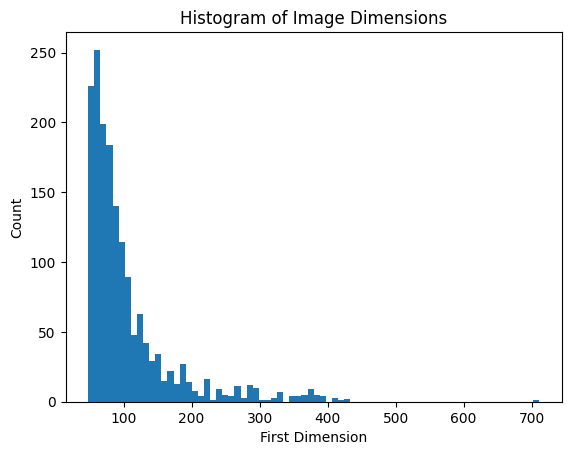

In [2]:
dataset = "../mldataset/cropped"
dirs = [os.path.join(dataset, "Meteors"), os.path.join(dataset, "Artifacts")]
dimensions = []

for i in dirs:
    for j in os.listdir(i):

        img = os.path.join(i, j)

        if "synthesized" in img:

            for synth in os.listdir(img):
                img3 = os.path.join(img, synth)

                img2 = Image.open(img3)
                img_array = np.array(img2)
                dimensions.append(img_array.shape[0])
                img_array = np.expand_dims(img_array, axis=-1)
        else:
            img = Image.open(img)
            img_array = np.array(img)
            dimensions.append(img_array.shape[0])
            img_array = np.expand_dims(img_array, axis=-1)

print("Number of images:", len(dimensions))
print("Mean:", np.mean(dimensions))
print("Geometric mean:", statistics.geometric_mean(dimensions))
print("Median:", np.median(dimensions))
print("Min:", np.min(dimensions))
print("Max:", np.max(dimensions))

q1 = np.percentile(dimensions, 25)
q3 = np.percentile(dimensions, 75)
iqr = q3 - q1
threshold = 1.5 * iqr
dimensions = np.sort(np.array(dimensions))
first_outlier = np.where((dimensions < q1 - threshold) | (dimensions > q3 + threshold))[
    0
]
print("Last non-outlier dimension:", dimensions[first_outlier[0] - 1])


plt.hist(dimensions, bins="auto")

plt.xlabel("First Dimension")
plt.ylabel("Count")
plt.title("Histogram of Image Dimensions")
plt.show()

In [3]:
confirmed_num = 0

confirmed_num += len(os.listdir(dirs[0]))
print("Number of meteor images:", confirmed_num)

rejected_images = []
rejected_num = 0

for filename in os.listdir(dirs[1]):
    if "synthesized" in filename:
        rejected_images += [
            os.path.join(dirs[1], filename, synth)
            for synth in os.listdir(os.path.join(dirs[1], filename))
        ]
    else:
        rejected_images.append(os.path.join(dirs[1], filename))

rejected_num = len(rejected_images)
print("Number of artifact images:", rejected_num)

Number of meteor images: 822
Number of artifact images: 822


## Class balancing using image augmentation


In [4]:
data_augmentation = tf.keras.Sequential(
    [
        # TODO: Modify data augmentation layers
        layers.RandomRotation(0.5),
    ]
)

# balance classes by using data augmentation
while rejected_num < confirmed_num:
    random_image = tf.random.shuffle(rejected_images)[0]
    random_image_path = random_image.numpy().decode("utf-8")
    if "synthesized" in random_image_path:
        continue
    img = Image.open(random_image_path)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=-1)

    img_array = data_augmentation(img_array)

    augmented_img = Image.fromarray(np.squeeze(img_array).astype(np.uint8))
    os.makedirs(os.path.join(dirs[1], "synthesized"), exist_ok=True)
    # Save the image
    base_filename = os.path.basename(random_image_path)[:-4] + "_augmented"
    full_path = os.path.join(dirs[1], "synthesized", base_filename + ".png")
    i = 1

    # Loop until we find a filename that does not already exist
    while os.path.exists(full_path):
        # If a file with the same name already exists, append the counter to the filename
        full_path = os.path.join(
            dirs[1], "synthesized", base_filename + "_" + str(i) + ".png"
        )
        # Increment the counter
        i += 1
    augmented_img.save(full_path)
    rejected_num += 1
print("Classes balanced.")
print("Number of meteor images:", confirmed_num)
print("Number of artifact images:", rejected_num)

Classes balanced.
Number of meteor images: 822
Number of artifact images: 822


## Dataset creation


In [5]:
IMG_SIZE = int(np.median(dimensions))  # seems about right
# IMG_SIZE = first_outlier
BATCH_SIZE = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset,
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
)

class_names = train_ds.class_names

Found 1644 files belonging to 2 classes.
Using 1151 files for training.
Using 493 files for validation.


### Dataset normalization


In [6]:
def standardize_image(image, label):
    """
    Linearly scales each image in image to have mean 0 and variance 1.
    """
    image = rescale(image)
    image = tf.image.per_image_standardization(image)

    return image, label


AUTOTUNE = tf.data.AUTOTUNE

rescale = layers.Rescaling(1.0 / 255)

# standardize each image to have mean 0 and variance 1
train_ds = train_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(standardize_image, num_parallel_calls=AUTOTUNE)

# buffered prefetching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Dataset visualization

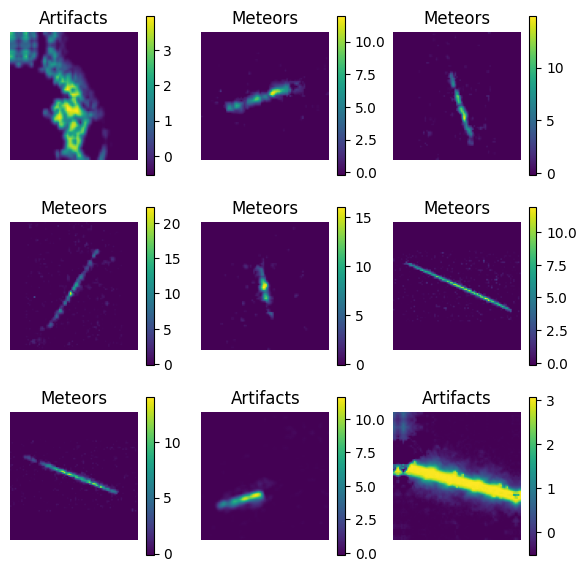

In [7]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("float32")

        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
        plt.colorbar()

## Model creation


In [34]:
# initial model from https://github.com/fiachraf/meteorml/blob/main/keras/training_scripts/CNN_script_20220325_1.py#L133
def model_builder(hp):
    global model_name
    model = models.Sequential()
    model_name = "CNN_20240504_1"
    model._name = model_name

    # added by me, so that these normalization steps arent done before the model
    # model.add(layers.Resizing(IMG_SIZE, IMG_SIZE))
    # model.add(layers.Rescaling(1.0 / 255))

    model.add(layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)))

    for i in range(hp.Int("num_conv_layers", 1, 3)):

        model.add(
            layers.Conv2D(hp.Int(f"conv_filter_num_{i}", min_value=2+3*i, max_value=10+5*i, step=2), hp.Int(f"conv_kernel_{i}", 3, 10), activation="relu",
                          )
        )
        if hp.Boolean(f"dropout_{i}"):
            model.add(layers.Dropout(rate=0.15))
        model.add(layers.MaxPooling2D(
            hp.Int(f"max_kernel_{i}", 2, 6), strides=hp.Int(f"max_stride_{i}", 1, 3)))

    # model.add(
    #    layers.Conv2D(12, 5, activation="relu")
    # )
    model.add(layers.Flatten())

    model.add(layers.Dense(units=hp.Int("dense_units", min_value=16,
              max_value=128, step=16), activation="relu"))
    model.add(layers.Dense(1, activation="sigmoid"))

    # hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizers.Adam(learning_rate=1e-4),
        metrics=[
            tf.keras.metrics.F1Score(
                name="f1", threshold=0.5, average="micro"),
            tf.keras.metrics.FalseNegatives(name="fn"),
        ],
    )

    return model

In [42]:
tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_f1", direction="max"),
    max_epochs=10,
    factor=3,
    directory="keras_tuner",
    project_name="GMNmeteorNet",
    #overwrite=True,
    hyperband_iterations=2,
)
tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
tuner.search(train_ds, epochs=2, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# models = tuner.get_best_models(num_models=2)

all_hyperparameters = best_hps.values
print(all_hyperparameters)

Trial 55 Complete [00h 00m 05s]
val_f1: 0.9726561903953552

Best val_f1 So Far: 0.9745596647262573
Total elapsed time: 00h 17m 13s
{'num_conv_layers': 2, 'conv_filter_num_0': 10, 'conv_kernel_0': 8, 'dropout_0': True, 'max_kernel_0': 3, 'max_stride_0': 2, 'dense_units': 112, 'conv_filter_num_1': 5, 'conv_kernel_1': 4, 'dropout_1': False, 'max_kernel_1': 2, 'max_stride_1': 2, 'conv_filter_num_2': 16, 'conv_kernel_2': 10, 'dropout_2': False, 'max_kernel_2': 3, 'max_stride_2': 2, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0017'}


In [43]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.summary()
json_config = hypermodel.to_json()

Model: "CNN_20240504_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 74, 74, 10)        650       
                                                                 
 dropout_2 (Dropout)         (None, 74, 74, 10)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 36, 36, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 33, 33, 5)         805       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 5)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1280)           

In [ ]:
json_config = hypermodel.to_json()
with open(f"models/{model_name}_config.json", "w") as json_file:
    json_file.write(json_config)

### Model architecture loading

In [9]:
with open(f"models/{model_name}_config.json", "r") as json_file:
    json_config = json_file.read()
model = models.model_from_json(json_config)

### Training model

In [44]:
EPOCHS = 10
history = hypermodel.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

val_f1_per_epoch = history.history["val_f1"]
best_epoch2 = val_f1_per_epoch.index(max(val_f1_per_epoch)) + 1
print(f"Best val_f1 epoch: {best_epoch2}")

Epoch 1/10


36/36 [==============================] - 1s 12ms/step - loss: 0.4909 - f1: 0.7909 - fn: 81.0000 - val_loss: 0.2794 - val_f1: 0.9470 - val_fn: 12.0000
Epoch 2/10
36/36 [==============================] - 0s 9ms/step - loss: 0.2150 - f1: 0.9272 - fn: 34.0000 - val_loss: 0.1606 - val_f1: 0.9606 - val_fn: 9.0000
Epoch 3/10
36/36 [==============================] - 0s 9ms/step - loss: 0.1477 - f1: 0.9431 - fn: 22.0000 - val_loss: 0.1322 - val_f1: 0.9665 - val_fn: 8.0000
Epoch 4/10
36/36 [==============================] - 0s 9ms/step - loss: 0.1186 - f1: 0.9610 - fn: 14.0000 - val_loss: 0.1195 - val_f1: 0.9663 - val_fn: 9.0000
Epoch 5/10
36/36 [==============================] - 0s 9ms/step - loss: 0.1044 - f1: 0.9688 - fn: 11.0000 - val_loss: 0.1114 - val_f1: 0.9684 - val_fn: 8.0000
Epoch 6/10
36/36 [==============================] - 0s 9ms/step - loss: 0.0907 - f1: 0.9731 - fn: 9.0000 - val_loss: 0.1088 - val_f1: 0.9684 - val_fn: 8.0000
Epoch 7/10
36/36 [==============================] - 0s 9

In [14]:
hypermodel.save(f"models/{model_name}.keras")

with open(f"models/{model_name}_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

### Loading model

In [14]:
model = models.load_model("models/{model_name}.keras")
with open(f"models/{model_name}_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)

## Result analysis

### Training results

Validation F1-Score: 0.9725490212440491


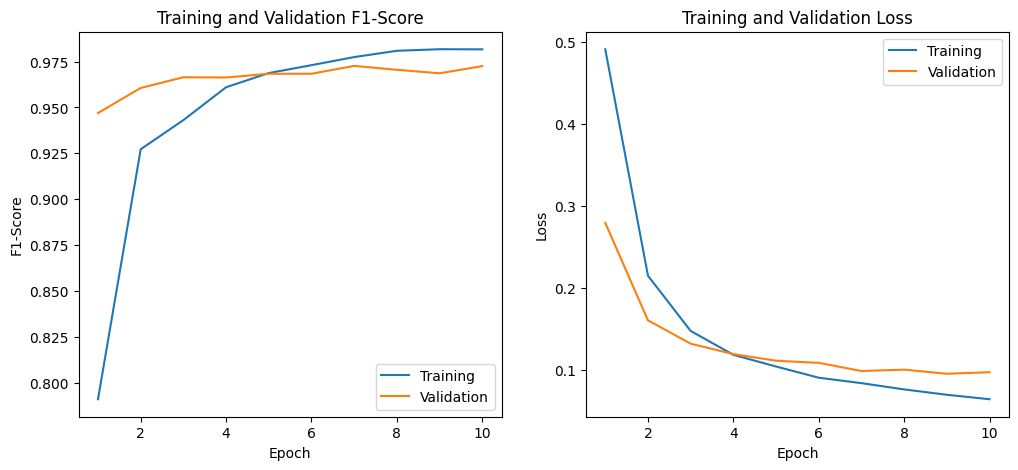

In [45]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
f1 = history.history["f1"]
val_f1 = history.history["val_f1"]

print("Validation F1-Score:", val_f1[-1])


epoch_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, f1, label="Training")
plt.plot(epoch_range, val_f1, label="Validation")
plt.title("Training and Validation F1-Score")
plt.xlabel("Epoch")
plt.ylabel("F1-Score")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, label="Training")
plt.plot(epoch_range, val_loss, label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [16]:
Y_pred = model.predict(val_ds)

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 8ms/step


### Confusion matrix

In [17]:
Y_pred_labels = np.squeeze(np.round(Y_pred))

Y_true = np.squeeze(np.concatenate([y for x, y in val_ds], axis=0))

confusion_mtx = tf.math.confusion_matrix(
    Y_true, Y_pred_labels, num_classes=2).numpy()
print("True positives:", confusion_mtx[1][1])
print("True negatives:", confusion_mtx[0][0])
print("False positives:", confusion_mtx[0][1])
print("False negatives:", confusion_mtx[1][0])
false_negatives = confusion_mtx[1][0]
false_positives = confusion_mtx[0][1]

True positives: 247
True negatives: 230
False positives: 10
False negatives: 6


False negatives: 6
False positives: 10


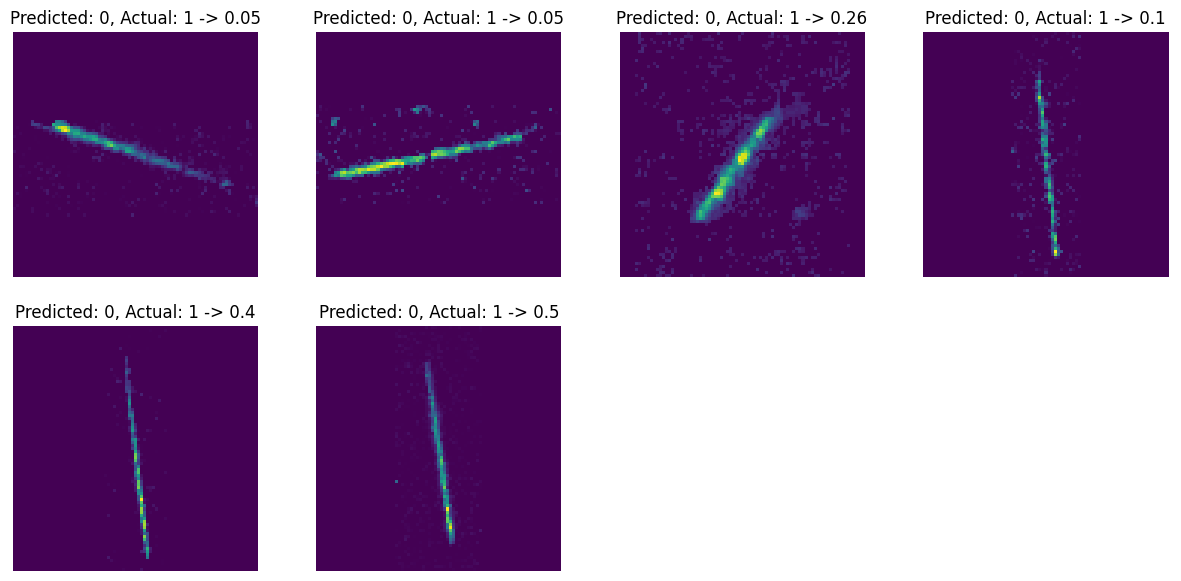

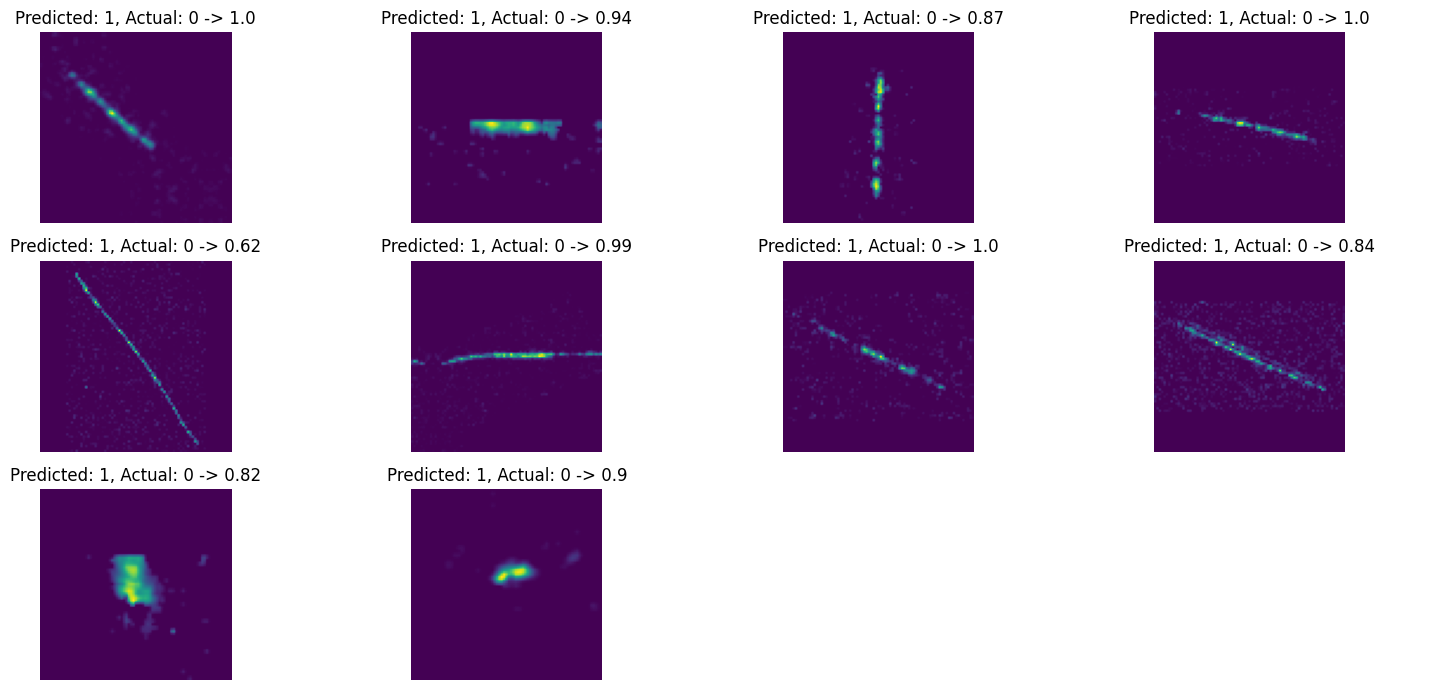

In [18]:
import math

columns_num = 4
fig, axes = plt.subplots(
    math.ceil(false_negatives / columns_num), columns_num, figsize=(15, 7)
)
fig2, axes2 = plt.subplots(
    math.ceil(false_positives / columns_num), columns_num, figsize=(15, 7)
)
for ax in axes.flatten():
    ax.axis("off")
for ax in axes2.flatten():
    ax.axis("off")

plt.subplots_adjust(hspace=0.05)
counter = 0
counter2 = 0
for i, (img, true_label) in enumerate(val_ds.unbatch()):
    if Y_pred_labels[i] == 0 and true_label == 1:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter // columns_num
        col = counter % columns_num
        counter += 1
        axes[row, col].imshow(img)
        prediction_confidence = str(round(prediction[0][0], 2))
        axes[row, col].set_title(
            f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
        )

    elif Y_pred_labels[i] == 1 and true_label == 0:

        img2 = img[np.newaxis, ...]
        # print(img2.shape)
        prediction = model.predict(img2, verbose=0)
        row = counter2 // columns_num
        col = counter2 % columns_num
        counter2 += 1
        axes2[row, col].imshow(img)
        prediction_confidence = str(round(prediction[0][0], 2))
        axes2[row, col].set_title(
            f"Predicted: {int(Y_pred_labels[i])}, Actual: {int(true_label)} -> {prediction_confidence}"
        )
print("False negatives:", counter)
print("False positives:", counter2)
plt.tight_layout()
plt.show()

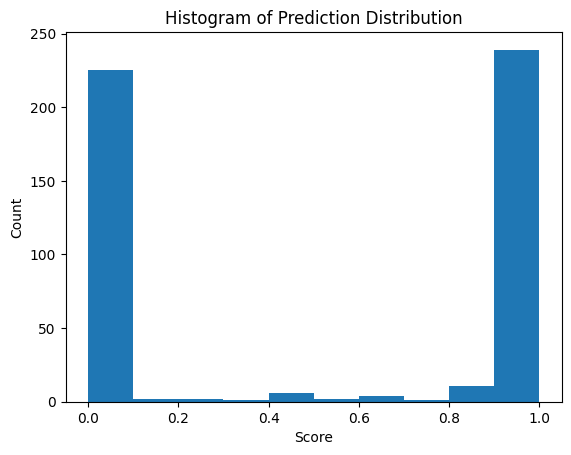

In [19]:
plt.hist(Y_pred, bins="auto")

plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Histogram of Prediction Distribution")
plt.show()

### Predicting single example

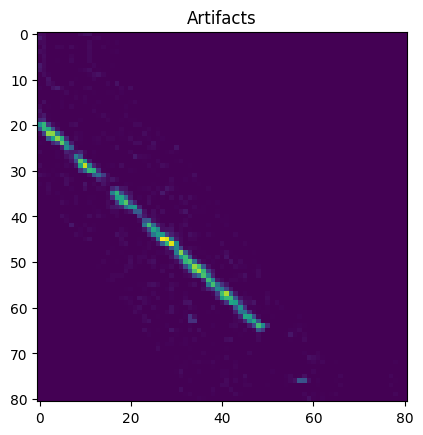

1/1 [==============================] - 0s 16ms/step
Prediction:           1.7215357956956723e-06 - > True


In [20]:
x = val_ds.shuffle(1000).take(1)
for img, lab in x:
    plt.figure()
    plt.imshow(img[0].numpy().astype("float32"))
    plt.title(f"{class_names[int(lab[0])]}")
    plt.show()
    img = img[0][np.newaxis, ...]
    prediction = model.predict(img)
    print(
        f"Prediction: \
          {prediction[0][0]} - > {class_names[int(np.round(prediction[0][0]))] == class_names[int(lab[0])]}"
    )
    break

### Testing Fiachra's model


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Correct predictions: 190 / 301
Test accuracy: [0.63122924]


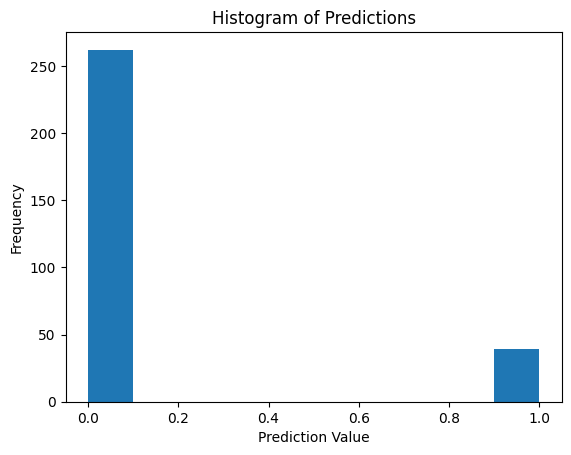

In [21]:
interpreter = tf.lite.Interpreter(model_path="meteorml32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on input data.
input_shape = input_details[0]["shape"]
correct_predictions = 0
total_predictions = 0

resize_32 = layers.Resizing(32, 32)
rescale = layers.Rescaling(1.0 / 255)
# Iterate over each batch
sample = val_ds.shuffle(1000).take(10)
predictions = []
for image_batch, label_batch in sample:
    total_predictions += image_batch.shape[0]

    for i in range(image_batch.shape[0]):
        img = resize_32(image_batch[i])
        # img=rescale(img)

        input_data = np.expand_dims(img, axis=0)
        interpreter.set_tensor(input_details[0]["index"], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]["index"])
        # print(output_data)
        # print(np.round(output_data)[0][0])

        # Get the highest scoring class
        prediction = int(np.round(output_data)[0][0])
        # print(prediction)
        predictions.append(prediction)
        # break
        correct_predictions += prediction == label_batch[i].numpy()


print("Correct predictions:", correct_predictions[0], "/", total_predictions)
# Calculate accuracy
accuracy = correct_predictions / total_predictions
print("Test accuracy:", accuracy)
plt.hist(predictions, bins="auto")
plt.title("Histogram of Predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")
plt.show()

Reason for such poor performance of the .tflite model is suspected to be because of drastic image resize to 32px where important image features might be lost making image classification difficult.